In [1]:
import pandas as pd
import numpy as np
import pickle
import glob
import os
import matplotlib.pyplot as plt
from geo_utils import calculate_dist

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

import utils

plt.style.use('seaborn-poster')

In [2]:
myshake_network_detection = pd.read_pickle('../data/myshake_detection_results.pkl')

# Get ShakeAlert messages
filename = '../data/shakeAlert/old_without_in_and_out/alerts2016.txt'
df_alert_2016, _ = utils.read_alert_data(filename, False)
filename = '../data/shakeAlert/old_without_in_and_out/alerts2018.txt'
df_alert_2018, _ = utils.read_alert_data(filename, False)

df_alert = pd.concat([df_alert_2016, df_alert_2018])

In [194]:
usgs_event_folder = '../data/ground_truth/'

In [195]:
first_alert_detection_compare = {}

for ground_truth_file in glob.glob(os.path.join(usgs_event_folder, '*')):
    evid = ground_truth_file.split('/')[-1].split('_')[0]
    earthquake = pickle.load(open(ground_truth_file, 'rb'))
    
    first_alert_detection_compare[evid] = {}
    first_alert_detection_compare[evid]['earthquake'] = earthquake
    
    # Get MyShake detection
    value = myshake_network_detection[evid]
    detection = value[0][0][0][0]
    if len(detection) == 0:
        myshake_detection_time = np.nan
        first_alert_detection_compare[evid]['myshake'] = [0, np.nan, np.nan, np.nan, np.nan]
    else: 
        dmag, dkm, dsecs, first_alert_time, total_opt_fails, npwave, nswave, first_centroid_error = value[0][1]
        first_alert_detection_compare[evid]['myshake'] = [1, first_alert_time, dmag, dsecs, dkm]
    
    # Get ShakeAlert detection
    shakealert_detection = df_alert[df_alert.evid == evid]
    
    if len(shakealert_detection) > 0:
        detection = shakealert_detection.iloc[0]
        first_alert_time = detection.alert_time
        dmag = detection.est_mag - earthquake['mag']
        #evtime = (pd.to_datetime(detection.date + 'T' + detection.time) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
        #dsecs = detection.
        dsecs = (pd.to_datetime(detection.est_date + 'T' + detection.est_time) - pd.to_datetime(earthquake['time'][:-1])).total_seconds()
        dkm = calculate_dist(earthquake['latitude'], earthquake['longitude'],
                            detection.est_evla, detection.est_evlo)
        
        first_alert_detection_compare[evid]['shakealert'] = [1, first_alert_time, dmag, dsecs, dkm]
    else:
        first_alert_detection_compare[evid]['shakealert'] = [0, np.nan, np.nan, np.nan, np.nan]    

## How many events each system detected

In [196]:
n_shakealert = 0
n_myshake = 0
n_both = 0
alert_time_diff_s_myshake_shakealert = []

myshake_only_detected = []
shakealert_only_detected = []
both_detected = []
neither_detected = []
all_earthquakes = []

dist_err_compare = []
mag_err_compare = []
alert_time_compare = []
for evid, detections in first_alert_detection_compare.items():
    myshake_detection = detections['myshake']
    shakealert_detection = detections['shakealert']
    earthquake = detections['earthquake']
    
    all_earthquakes.append([earthquake['latitude'], earthquake['longitude'], earthquake['mag']])
    
    if myshake_detection[0]:
        n_myshake += 1
    
    if shakealert_detection[0]:
        n_shakealert += 1
        if shakealert_detection[1] ==9999:
            print('Here')
    
    # Both system detected
    if (myshake_detection[0]) & (shakealert_detection[0]):
        n_both += 1
        alert_time_diff_s_myshake_shakealert.append(myshake_detection[1] - shakealert_detection[1])
        both_detected.append([earthquake['latitude'], earthquake['longitude']])
        dist_err_compare.append([myshake_detection[4], shakealert_detection[4]])
        mag_err_compare.append([myshake_detection[2], shakealert_detection[2]])
        alert_time_compare.append([myshake_detection[2], shakealert_detection[2]])
    
    # Only MyShake detected
    if (myshake_detection[0]) & (shakealert_detection[0]==0):
        print(evid)
        myshake_only_detected.append([earthquake['latitude'], earthquake['longitude'], earthquake['mag']])
        
    # Only ShakeAlert detected
    if (myshake_detection[0]==0) & (shakealert_detection[0]):
        shakealert_only_detected.append([earthquake['latitude'], earthquake['longitude'], earthquake['mag']])
        
    # None of the system detected
    if (myshake_detection[0]==0) & (shakealert_detection[0]==0):
        neither_detected.append([earthquake['latitude'], earthquake['longitude'], earthquake['mag']])
        
myshake_only_detected = np.array(myshake_only_detected)
shakealert_only_detected = np.array(shakealert_only_detected)
both_detected = np.array(both_detected)
neither_detected = np.array(neither_detected)
all_earthquakes = np.array(all_earthquakes)
dist_err_compare = np.array(dist_err_compare)
mag_err_compare = np.array(mag_err_compare)
alert_time_compare = np.array(alert_time_compare)


ci37255980
ci38230144
ci38238754
ci37219484
ci38449719
ci38460951
ci37260284
nc72974766
ci37258076
ci37374890


In [197]:
print(f'Out of {len(first_alert_detection_compare)} events:\n'
      f'    MyShake detected: {n_myshake}\n'
      f'    ShakeAlert detected: {n_shakealert}\n'
      f'    {n_both} events detected by both system.')

Out of 785 events:
    MyShake detected: 112
    ShakeAlert detected: 475
    102 events detected by both system.


## Plot the detections

In [198]:
min_v = min(alert_time_diff_s_myshake_shakealert)
max_v = max(alert_time_diff_s_myshake_shakealert)

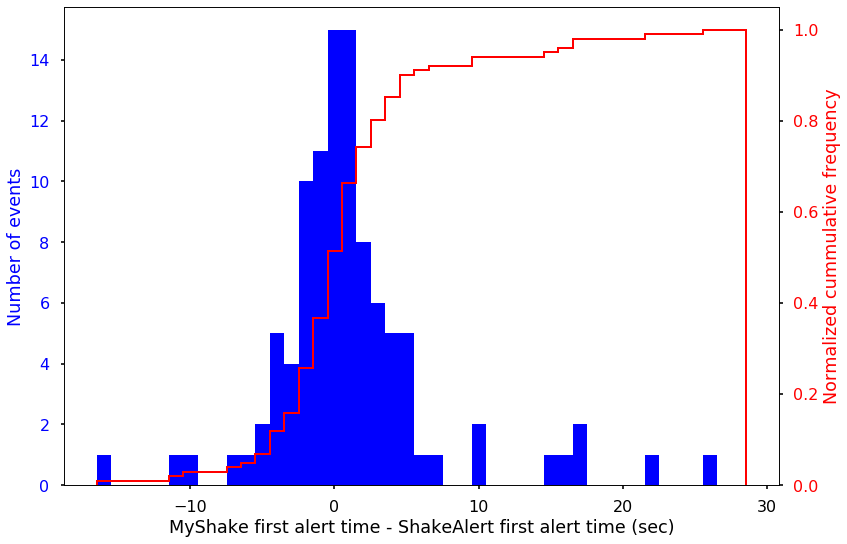

In [199]:
fig, ax1 = plt.subplots()
ax1.hist(alert_time_diff_s_myshake_shakealert, bins=np.arange(min_v, max_v), 
        color='b')
ax1.set_xlabel('MyShake first alert time - ShakeAlert first alert time (sec)')
ax1.set_ylabel('Number of events', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()  # 
ax2.hist(alert_time_diff_s_myshake_shakealert, bins=np.arange(min_v, max_v),
        cumulative=True, histtype='step', linewidth=2, color='r', density=True)
ax2.set_xlabel('MyShake first alert time - ShakeAlert first alert time (sec)')
ax2.set_ylabel('Normalized cummulative frequency', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.savefig("alert_time_difference.jpg", bbox_inches = 'tight', dpi=300,
    pad_inches = 0.1)
plt.show()

Text(0, 0.5, 'ShakeAlert distance error (km)')

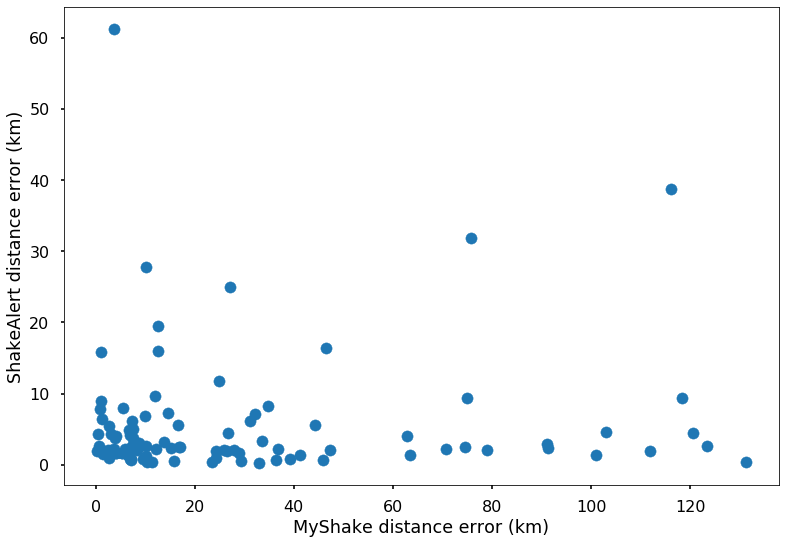

In [200]:
plt.scatter(dist_err_compare[:, 0],
            dist_err_compare[:, 1])
plt.xlabel('MyShake distance error (km)')
plt.ylabel('ShakeAlert distance error (km)')

Text(0, 0.5, 'ShakeAlert magnitude error')

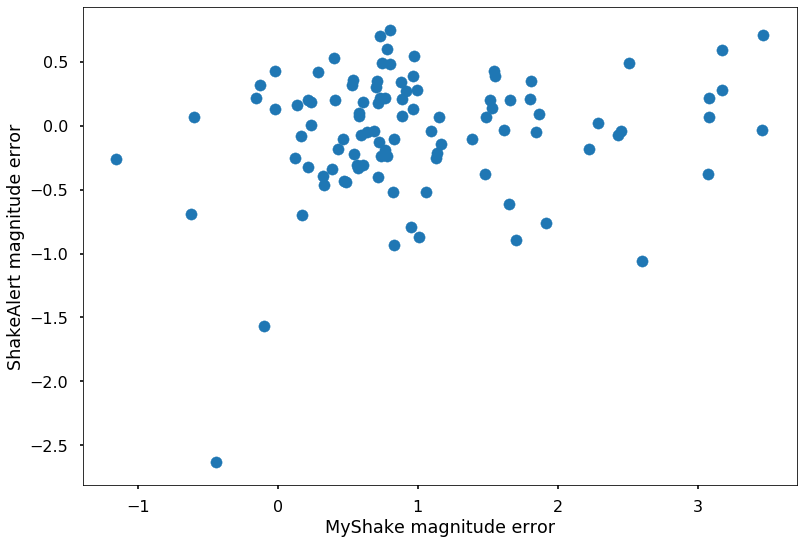

In [201]:
plt.scatter(mag_err_compare[:, 0],
            mag_err_compare[:, 1])
plt.xlabel('MyShake magnitude error')
plt.ylabel('ShakeAlert magnitude error')

##  Plot on the map

In [162]:
def plot_scatter_on_map(x,
                        y,
                        c,
                        s,
                        vmin = 0,
                        vmax = 100,
                        clabel=None,
                        filename=None,
                        resolution='50m',
                        title=None,
                        llat=32,
                        ulat=42.2,
                        llon=-125,
                        ulon=-114,
                       **kwarg):
    
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())
        
    ax.add_feature(cfeature.LAND.with_scale(resolution))
    ax.add_feature(cfeature.OCEAN.with_scale(resolution))
    ax.add_feature(cfeature.COASTLINE.with_scale(resolution))
    ax.add_feature(cfeature.BORDERS.with_scale(resolution), linestyle=':')
    ax.add_feature(cfeature.LAKES.with_scale(resolution), alpha=0.5)
    ax.add_feature(cfeature.RIVERS.with_scale(resolution))
    ax.add_feature(cfeature.STATES.with_scale(resolution))
    
    cs = ax.scatter(x, y, marker='o',
                    s=s, c=c, vmin=vmin, 
                    vmax=vmax, zorder=10, **kwarg)
    if clabel is not None:
        cbar = plt.colorbar(cs)
        cbar.set_label(clabel)
    
    plt.title(title)
    
    if filename:
        plt.savefig(filename, bbox_inches = 'tight',
        pad_inches = 0.1)
    else:
        plt.show()

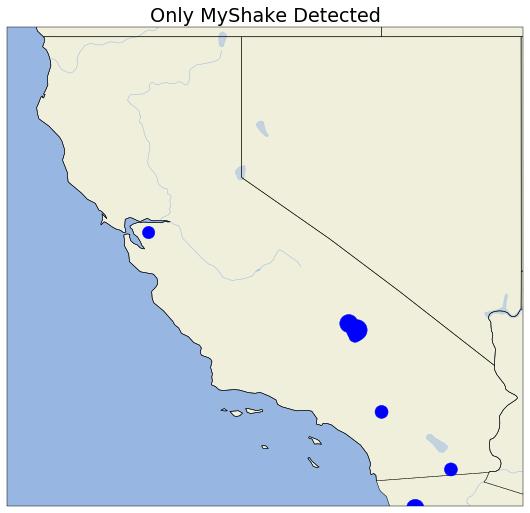

In [163]:
plot_scatter_on_map(
    myshake_only_detected[:, 1],
    myshake_only_detected[:, 0],
    c='b',
    s=myshake_only_detected[:, 2]**4,
    vmin = None,
    vmax = None,
    clabel=None,
    filename=None,
    title='Only MyShake Detected',)

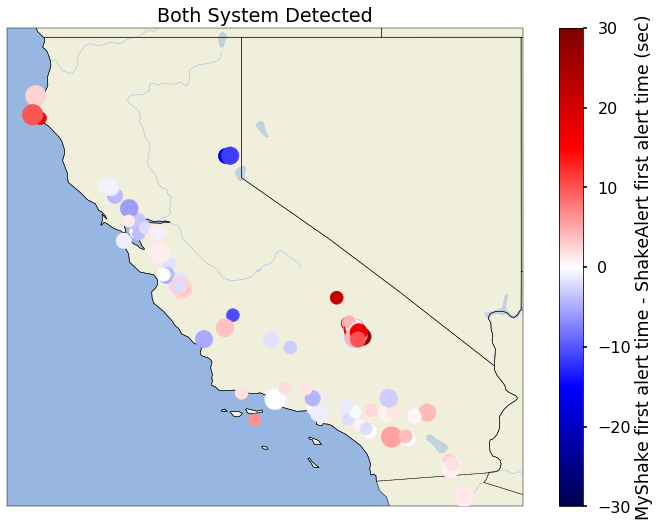

In [205]:
plot_scatter_on_map(
    both_detected[:, 1],
    both_detected[:, 0],
    c=alert_time_diff_s_myshake_shakealert,
    s=myshake_only_detected[:, 2]**4,
    vmin = -30,
    vmax = 30,
    clabel='MyShake first alert time - ShakeAlert first alert time (sec)',
    filename='both_system_detected.jpg',
    title='Both System Detected',
    cmap=plt.cm.seismic)

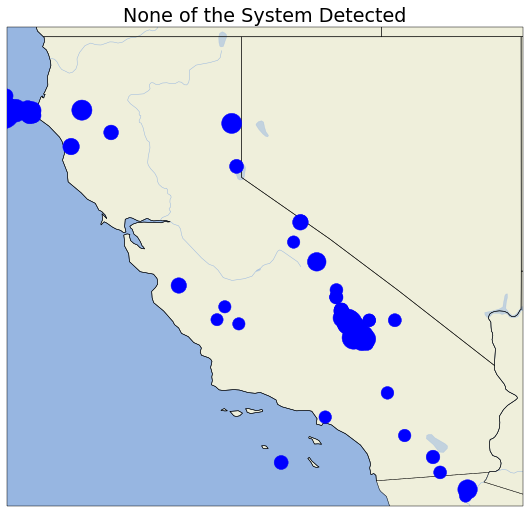

In [165]:
plot_scatter_on_map(
    neither_detected[:, 1],
    neither_detected[:, 0],
    c='b',
    s=neither_detected[:, 2]**4,
    vmin = None,
    vmax = None,
    clabel=None,
    filename=None,
    title='None of the System Detected',
    cmap=plt.cm.seismic)

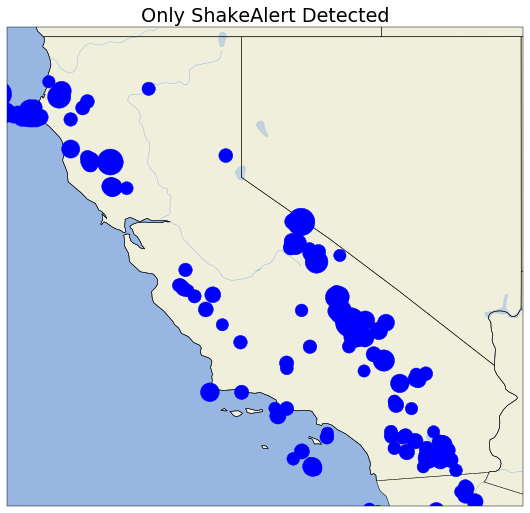

In [204]:
plot_scatter_on_map(
    shakealert_only_detected[:, 1],
    shakealert_only_detected[:, 0],
    c='b',
    s=shakealert_only_detected[:, 2]**4,
    vmin = None,
    vmax = None,
    clabel=None,
    title='Only ShakeAlert Detected',
    cmap=plt.cm.seismic,
    filename='only_shakealert_detected.jpg')